In [ ]:
### Bayesian test for correlation with ZDJ prior

In [1]:
### General imports
import pandas as pd
import xarray as xr
import re
import numpy as np
import urllib.request

### Plots
import matplotlib.pyplot as plt
import seaborn as sns

#Stats
from scipy.special import gamma
from scipy.integrate import quad

In [2]:
### Color list 
dark_oranges = sns.color_palette("Oranges", n_colors=15)[4:]
dar_purples = sns.color_palette("Purples", n_colors=9)[4:]
dark_greens = sns.color_palette("Greens", n_colors=9)[4:]

In [3]:
# URL of the data file
url = "https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT5.0Analysis_gl.txt"

# Fetch the data from the URL
with urllib.request.urlopen(url) as response:
    lines = response.read().decode('utf-8').splitlines()

# Parse the lines to extract the data
data = []
months = []
years = []
for line in lines[::2]:
    values = line.split(' ')[2:-1]
    years.append(line.split(' ')[0])
    years.append(line.split(' ')[1])
    for i, value in enumerate(values):
        if value != '':
            data.append(value)
            months.append(i)

# Convert the list of lists into a NumPy array
data_array = np.array(data, dtype=float)
data_array = data_array

# Print the resulting NumPy array
print(data_array)

time = pd.date_range(start='1850-01-01', end='2025-12-01', freq='MS')
HadCRUT5 = xr.DataArray(
    data_array[:], 
    coords={'time': time}, 
    dims='time', 
    name='temperature - HadCRU5'
)

HadCRUT5_annual = HadCRUT5.groupby('time.year').mean(dim='time')

[-0.734 -0.36  -0.627 ... -9.999 -9.999 -9.999]


In [4]:
# Anomaly relative to 1951–1980
HadCRUT5_annual_anom = HadCRUT5_annual - HadCRUT5_annual.sel(year=slice('1951','1980')).mean(dim='year')

# --- Prep data assumed available: ds with 'year' and 'GMST' ---
t = np.asarray(HadCRUT5_annual_anom['year'].values).astype(float)
y = HadCRUT5_annual_anom.values.astype(float)

In [5]:
# Focus period (as in your code)
mask_short = (t >= 1950) & (t <= 2022)
t_short = t[mask_short]
y_short = y[mask_short]
n = len(y_short)

# =========================
# Linear model (full period)
# =========================
X_lin = np.column_stack([np.ones(n), t_short])
beta_lin, *_ = np.linalg.lstsq(X_lin, y_short, rcond=None)
yhat_lin = X_lin @ beta_lin
resid_lin = y_short - yhat_lin

# =========================
# ENSO (ONI) loading & annual mean
# =========================
oni_path = '/home/jmindlin/BF_codes/data/oni_data.txt'

def load_oni_xarray(src):
    # Adjust reading logic to your file; this mirrors your approach.
    df_oni = np.loadtxt(src, skiprows=1, max_rows=76)
    oni = np.concatenate([df_oni[i, 1:13].flatten() for i in range(df_oni.shape[0]-1)])
    t_monthly = pd.date_range('1950-01-01', '2025-01-01', freq='ME')
    da = xr.DataArray(
        oni, dims=["time"], coords={"time": t_monthly}, name="oni",
        attrs={"units": "degC", "source": "NOAA"}
    )
    return da

oni = load_oni_xarray(oni_path)
oni_annual = oni.groupby('time.year').mean(dim='time')  # annual mean 1950–2024
oni_years = oni_annual['year'].values.astype(int)
oni_vals = oni_annual.values

# =========================
# Quadratic detrending (1950–2024)
# =========================
X_quad = np.column_stack([np.ones(len(t_short)), t_short, t_short**2])
beta_quad, *_ = np.linalg.lstsq(X_quad, y_short, rcond=None)
yhat_quad_shortPeriod = X_quad @ beta_quad
resid_quad_shortPeriod = y_short - yhat_quad_shortPeriod

# =========================
# Align ONI to years of GMST residuals
# =========================
t_enso_years = t_short.astype(int)
oni_map = {int(yy): float(val) for yy, val in zip(oni_years, oni_vals)}
oni_aligned = np.array([oni_map.get(int(yy), np.nan) for yy in t_enso_years], dtype=float)

valid = ~np.isnan(oni_aligned)
t_enso = t_short[valid]
y_enso = resid_quad_shortPeriod[valid]
oni_aligned = oni_aligned[valid]
n = len(y_enso)

# =========================
# Quadratic detrending (1950–2024)
# =========================
X_quad = np.column_stack([np.ones(len(t_enso)), t_enso, t_enso**2])
beta_quad, *_ = np.linalg.lstsq(X_quad, y_enso, rcond=None)
yhat_quad_shortPeriod = X_quad @ beta_quad
resid_quad_shortPeriod = y_short - yhat_quad_shortPeriod

# =========================
# Diagnostics / statistics
# =========================
# Pearson correlation and p-value (two-sided)
from scipy.stats import pearsonr, t as student_t
r, p = pearsonr(y_enso, oni_aligned)

# R^2 from simple regression of residuals on ONI
X_enso = np.column_stack([np.ones(n), oni_aligned])
# beta_enso, *_ = np.linalg.lstsq(X_enso, y_enso, rcond=None)
beta_enso, *_ = np.linalg.lstsq(X_enso, y_enso, rcond=None) 
yhat_enso = X_enso @ beta_enso
resid_enso = y_enso - yhat_enso
RSS_enso = np.sum(resid_enso**2)
TSS_enso = np.sum((y_enso - np.mean(y_enso))**2)
R2_enso = 1 - RSS_enso / TSS_enso

# JZS Bayes factor for k=1 predictor using the Wetzels & Wagenmakers setup

def bayes_factor_JZS(n, k, R2):
    """
    JZS Bayes factor for linear regression with k predictors (excluding intercept).
    Mirrors the 1D integral used in Wetzels & Wagenmakers (2012).
    """
    def integrand(g):
        return (1 + g)**((n - k - 1) / 2) * (1 + (1 - R2) * g)**(-(n - 1) / 2) * g**(-3 / 2) * np.exp(-n / (2 * g))
    integral, _ = quad(integrand, 0, np.inf, limit=200)
    # Prefactor; reduces to a simple function of n when k=1
    BF = ((n / 2)**(k / 2) * gamma((k + 1) / 2)) / (np.sqrt(np.pi) * gamma(k / 2)) * integral
    return BF

BF10 = bayes_factor_JZS(n=n, k=1, R2=R2_enso)
BF01 = 1.0 / BF10

# =========================
# Regression coefficient
# ========================
slope_enso = beta_enso[1]
intercept_enso = beta_enso[0]



/tmp/ipykernel_2445928/106408736.py:32: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axs[0].text(


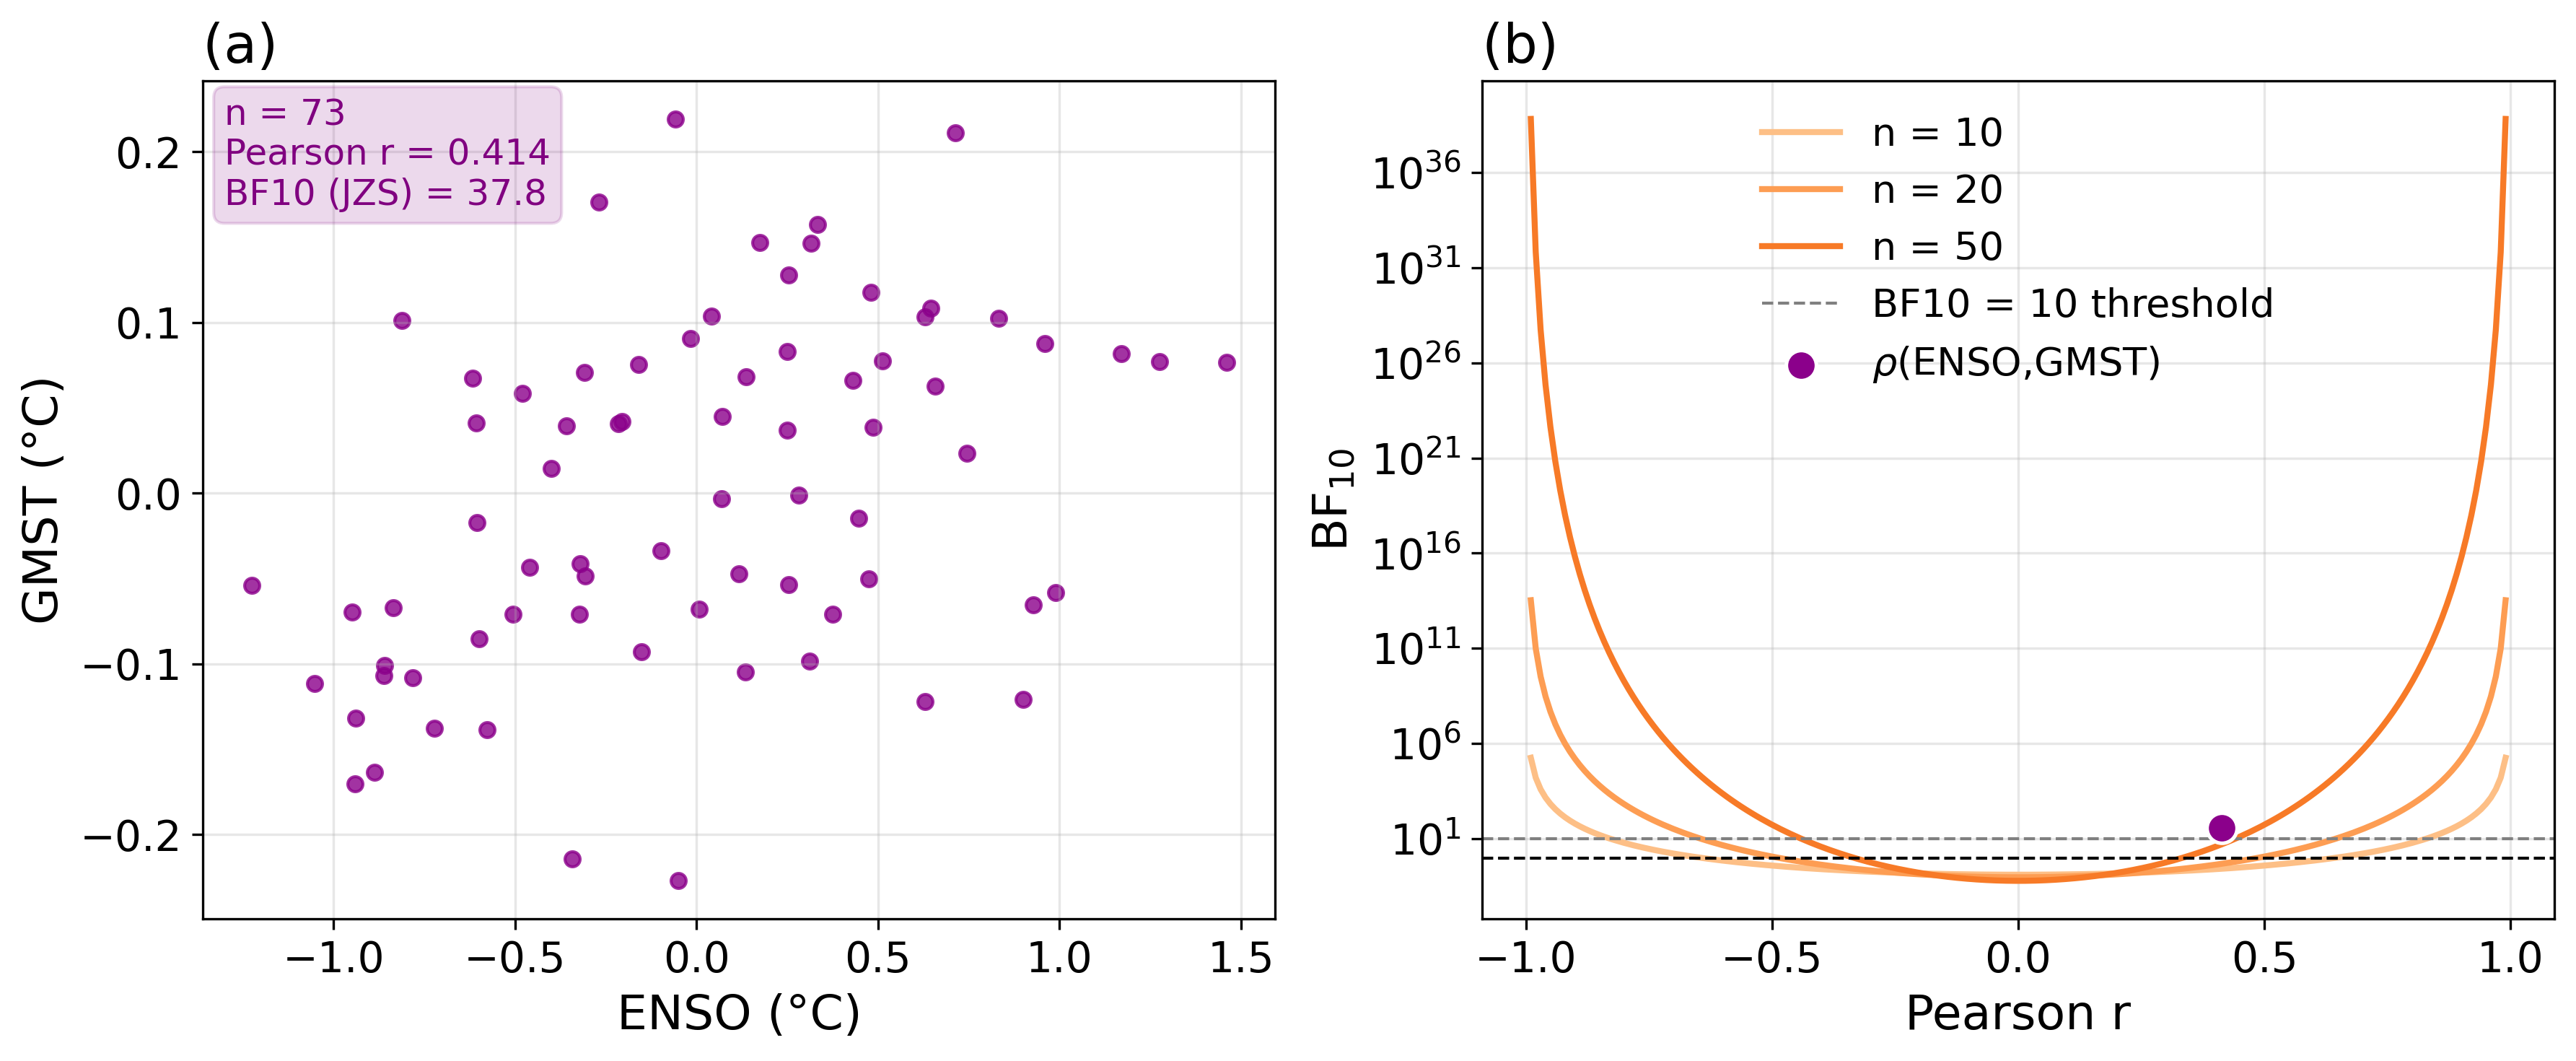

In [24]:
# === FONT SETTINGS ===
TITLE_FONTSIZE = 18
LABEL_FONTSIZE = 16
TICK_FONTSIZE  = 14
LEGEND_FONTSIZE = 13
ANNOT_FONTSIZE = 12

# === Data and setup ===
ns = [10, 20, 50]
rs = np.linspace(-0.99, 0.99, 200)

# Example annotation text
txt = (
    f"n = {n}\n"
    f"Pearson r = {r:.3f}\n"
    f"BF10 (JZS) = {BF10:.3g}"
)

# === Figure ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

# === Panel (a): Scatter plot ===
axs[0].scatter(oni_aligned, y_enso, alpha=0.8, s=25,
               color='darkmagenta', label='Data points')
axs[0].set_xlabel('ENSO (°C)', fontsize=LABEL_FONTSIZE)
axs[0].set_ylabel('GMST (°C)', fontsize=LABEL_FONTSIZE)
axs[0].set_title('(a) ', loc='left',fontsize=TITLE_FONTSIZE)
axs[0].tick_params(axis='both', labelsize=TICK_FONTSIZE)
axs[0].grid(alpha=0.3)

# Annotation box (top-left)
axs[0].text(
    0.02, 0.98, txt,
    transform=axs[0].transAxes,
    va='top', ha='left',
    fontsize=ANNOT_FONTSIZE,
    color='purple',
    bbox=dict(boxstyle="round", alpha=0.15, color='purple', edgecolor='none')
)

# === Panel (b): JZS Bayes Factor curves ===
for i, n_val in enumerate(ns):
    BF_vals = [bayes_factor_JZS(n=n_val, k=1, R2=r_val**2) for r_val in rs]
    axs[1].plot(rs, BF_vals, color=dark_oranges[i*2], label=f'n = {n_val}', lw=2)

# Add lines and highlight point
axs[1].axhline(10, color='gray', linestyle='--', linewidth=1, label='BF10 = 10 threshold')
axs[1].axhline(1, color='k', linestyle='--', linewidth=1)
axs[1].scatter(r, BF10, color='darkmagenta', s=100, edgecolor='white', linewidth=1.2, zorder=5,
               label=r'$\rho$(ENSO,GMST)')

# Axes formatting
axs[1].set_yscale('log')
axs[1].set_xlabel('Pearson r', fontsize=LABEL_FONTSIZE)
axs[1].set_ylabel(r'BF$_{10}$', fontsize=LABEL_FONTSIZE)
# axs[1].set_title('(b) JZS Bayes Factor vs Pearson r (varying n)', fontsize=TITLE_FONTSIZE)
axs[1].set_title('(b) ', loc='left', fontsize=TITLE_FONTSIZE)
axs[1].tick_params(axis='both', labelsize=TICK_FONTSIZE)
axs[1].legend(fontsize=LEGEND_FONTSIZE, frameon=False)
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [7]:
import xarray as xr

# === Load Tmin and Tmax ===
tmin = xr.open_dataset("/climca/data/OBS/CPC/cpc_data/tmax_1979_2024_mon.nc")['tmax']
tmax = xr.open_dataset("/climca/data/OBS/CPC/cpc_data/tmin_1979_2024_mon.nc")['tmin']

# === Compute Tmean ===
tmean = (tmin + tmax) / 2
tmean.name = "tmean"
tmean.attrs['units'] = tmin.attrs.get('units', 'degC')
tmean.attrs['long_name'] = "Monthly Mean Temperature"

pr = xr.open_dataset("/climca/data/OBS/CPC/cpc_data/precip_1979_2024_mon.nc")['precip']


In [8]:
### Compute correlation between tmean and ONI for Sep-Nov, use oni (no annual mean
# Select Sep-Nov months
tmean_son = tmean.sel(time=tmean['time.month'].isin([10, 11, 12]))
pr_son = pr.sel(time=pr['time.month'].isin([10, 11, 12]))
oni_son = oni.sel(time=oni['time.month'].isin([10, 11, 12]))
# Group by year and compute mean
tmean_son_annual = tmean_son.groupby('time.year').mean(dim='time')
oni_son_annual = oni.groupby('time.year').mean(dim='time').sel(year=slice('1979','2024'))
pr_son_annual = pr_son.groupby('time.year').mean(dim='time')
# Align years with ONI
tmean_years = tmean_son_annual['year'].values.astype(int)


In [9]:
import numpy as np
import xarray as xr
from scipy.stats import pearsonr

# assume you already have: tmean_son_annual (with dim 'year' + spatial dims)
# and oni_son_annual (1D DataArray with dim 'year')
# and a function bayes_factor_JZS(n, k, R2)

import numpy as np
from scipy.stats import pearsonr

def compute_correlation_bf_p(y, x):
    """
    y, x: 1D arrays along 'year'
    returns: (r, BF10, p)
    """
    # handle NaNs
    mask = np.isfinite(y) & np.isfinite(x)
    y_ = y[mask]
    x_ = x[mask]

    # not enough data → NaNs
    if y_.size < 3:
        return np.nan, np.nan, np.nan

    r, p = pearsonr(y_, x_)
    R2 = r**2
    n = y_.size

    BF10 = bayes_factor_JZS(n=n, k=1, R2=R2)
    return r, BF10, p


import numpy as np
from scipy.stats import pearsonr

def compute_correlation_bf_p(y, x):
    """
    y, x: 1D arrays along 'year'
    Steps:
      - remove NaNs
      - linearly detrend both y and x
      - standardize (z-score) both
      - compute r, BF10 (JZS), and p
    returns: (r, BF10, p)
    """
    # handle NaNs
    mask = np.isfinite(y) & np.isfinite(x)
    y_ = np.asarray(y)[mask]
    x_ = np.asarray(x)[mask]

    # not enough data → NaNs
    if y_.size < 3:
        return np.nan, np.nan, np.nan

    n = y_.size
    t = np.arange(n)

    # --- detrend y ---
    coef_y = np.polyfit(t, y_, 1)
    trend_y = np.polyval(coef_y, t)
    y_d = y_ - trend_y

    # --- detrend x ---
    coef_x = np.polyfit(t, x_, 1)
    trend_x = np.polyval(coef_x, t)
    x_d = x_ - trend_x

    # --- standardize (z-score) ---
    y_std = y_d.std(ddof=1)
    x_std = x_d.std(ddof=1)
    if y_std == 0 or x_std == 0 or not np.isfinite(y_std) or not np.isfinite(x_std):
        return np.nan, np.nan, np.nan

    y_z = (y_d - y_d.mean()) / y_std
    x_z = (x_d - x_d.mean()) / x_std

    # correlation & p
    r, p = pearsonr(y_z, x_z)
    R2 = r**2

    BF10 = bayes_factor_JZS(n=n, k=1, R2=R2)
    return r, BF10, p


In [10]:
r_map_enso, bf_map_enso, p_map_enso = xr.apply_ufunc(
    compute_correlation_bf_p,
    pr_son_annual,
    oni_son_annual,
    input_core_dims=[['year'], ['year']],
    output_core_dims=[[], [], []],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float, float, float],
    # or instead of explicit align: join='inner'
    # join='inner',
)

r_map_enso = r_map_enso.rename("r")
bf_map_enso = bf_map_enso.rename("BF10")
p_map_enso = p_map_enso.rename("p")

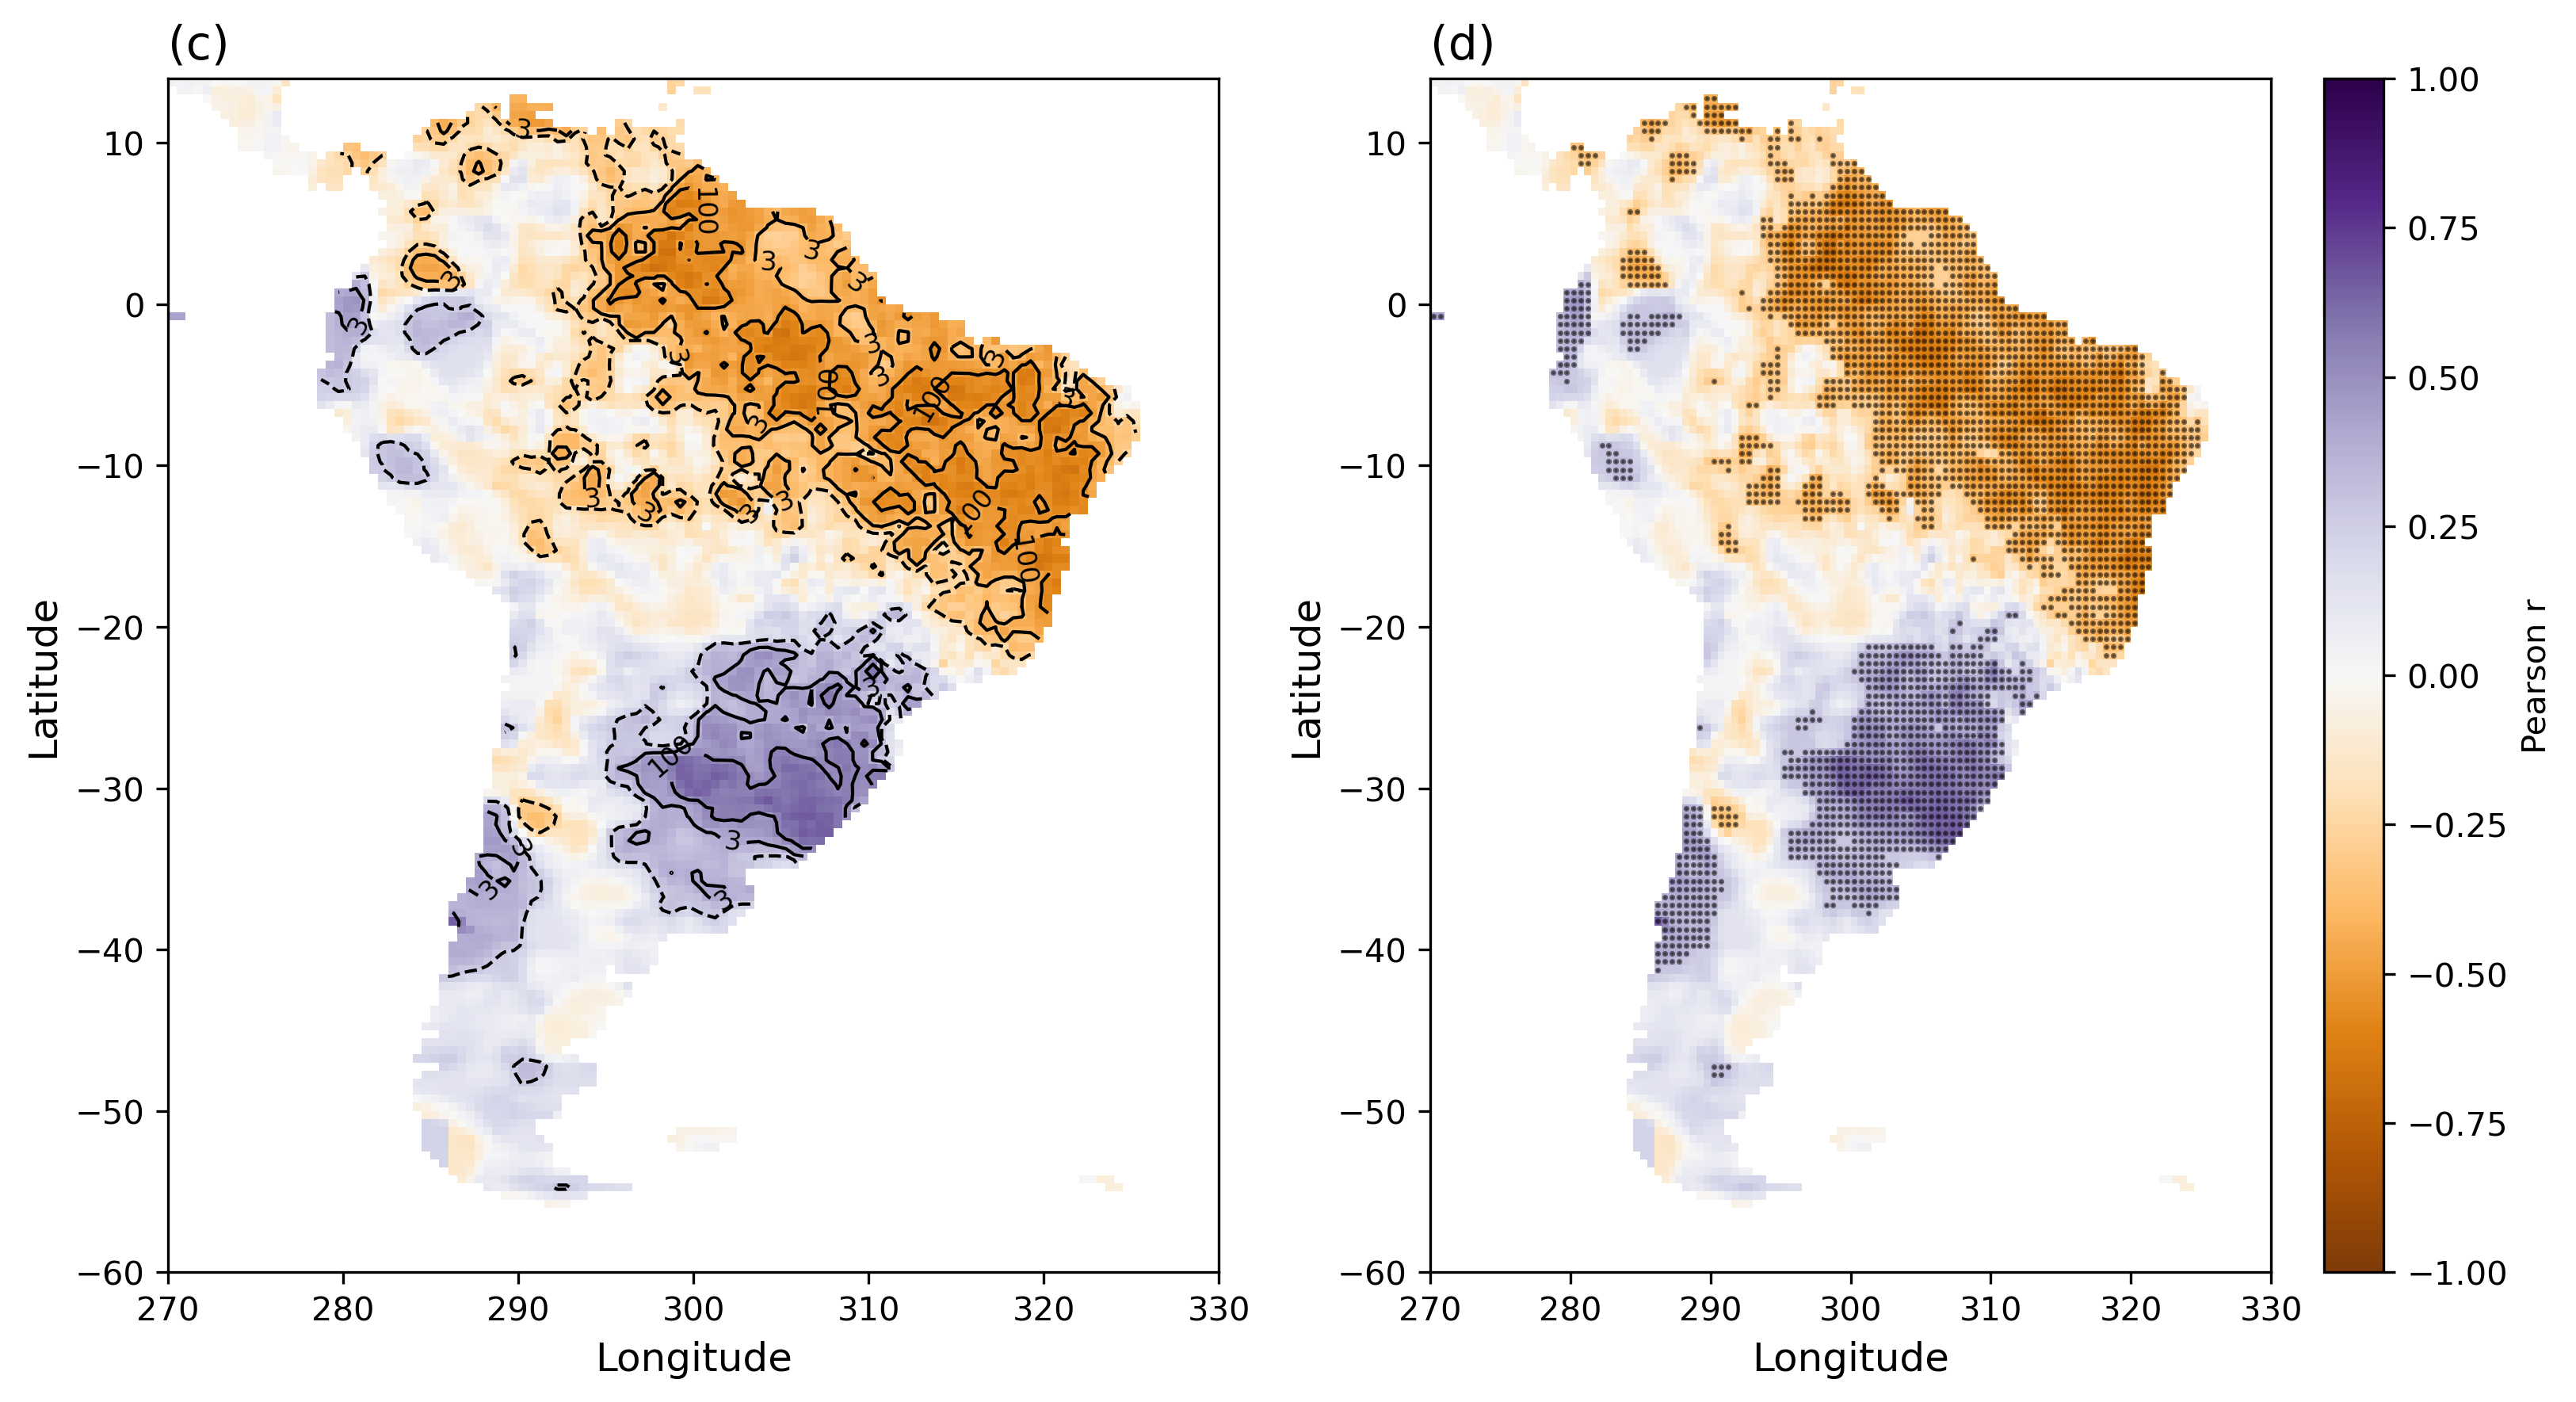

In [20]:
# === Limit to South America (assuming lon 0–360, lat ascending) ===
sa = dict(lon=slice(270, 330), lat=slice(14, -60))

r_sa = r_map_enso.sel(**sa)
bf_sa = bf_map_enso.sel(**sa)
p_sa = p_map_enso.sel(**sa)   # make sure you have p_map_pr from your apply_ufunc

## levels showing where bf are larger than 3
bf_levels = [3, 100]

bf_levels_no_ev = [1/3]

fig, axs = plt.subplots(1, 2, figsize=(11, 6), dpi=300)

# ============================
# 1) Correlation (r) map + BF contours
# ============================
im0 = axs[0].pcolormesh(
    r_sa['lon'], r_sa['lat'], r_sa,
    cmap='PuOr', vmin=-1, vmax=1
)
axs[0].set_title(r'(c)     ', loc='left', fontsize=14)

cs0 = axs[0].contour(
    bf_sa['lon'], bf_sa['lat'], bf_sa,
    levels=bf_levels,
    colors='k',
    linewidths=1
)
axs[0].clabel(cs0, inline=True, fontsize=8, fmt='%d')

cs0 = axs[0].contour(
    bf_sa['lon'], bf_sa['lat'], bf_sa,
    levels=bf_levels_no_ev,
    colors='k',
    linewidths=1,
    linestyles='dashed'
)

# axs[0].clabel(cs0, inline=True, fontsize=8, fmt='%d')


# ============================
# 2) Correlation map + stippling where p < 0.05
# ============================
im1 = axs[1].pcolormesh(
    r_sa['lon'], r_sa['lat'], r_sa,
    cmap='PuOr', vmin=-1, vmax=1
)
axs[1].set_title('(d)', loc='left', fontsize=14)

# Create stippling mask
sig = p_sa < 0.05

# Build 2D lon/lat arrays for scatter
lon2d, lat2d = np.meshgrid(r_sa['lon'].values, r_sa['lat'].values)

# Stipple significant points
axs[1].scatter(
    lon2d[sig],
    lat2d[sig],
    s=2,
    color='k',
    marker='.',
    alpha=0.5
)

### Set axis labels latitude longitude
axs[0].set_xlabel('Longitude', fontsize=12)
axs[0].set_ylabel('Latitude', fontsize=12)
axs[1].set_xlabel('Longitude', fontsize=12)
axs[1].set_ylabel('Latitude', fontsize=12)

fig.colorbar(im1, ax=axs[1], label='Pearson r')

plt.tight_layout()
# plt.show()
extent = axs[0].get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
fig.savefig("panelA.png", dpi=300, bbox_inches=extent)


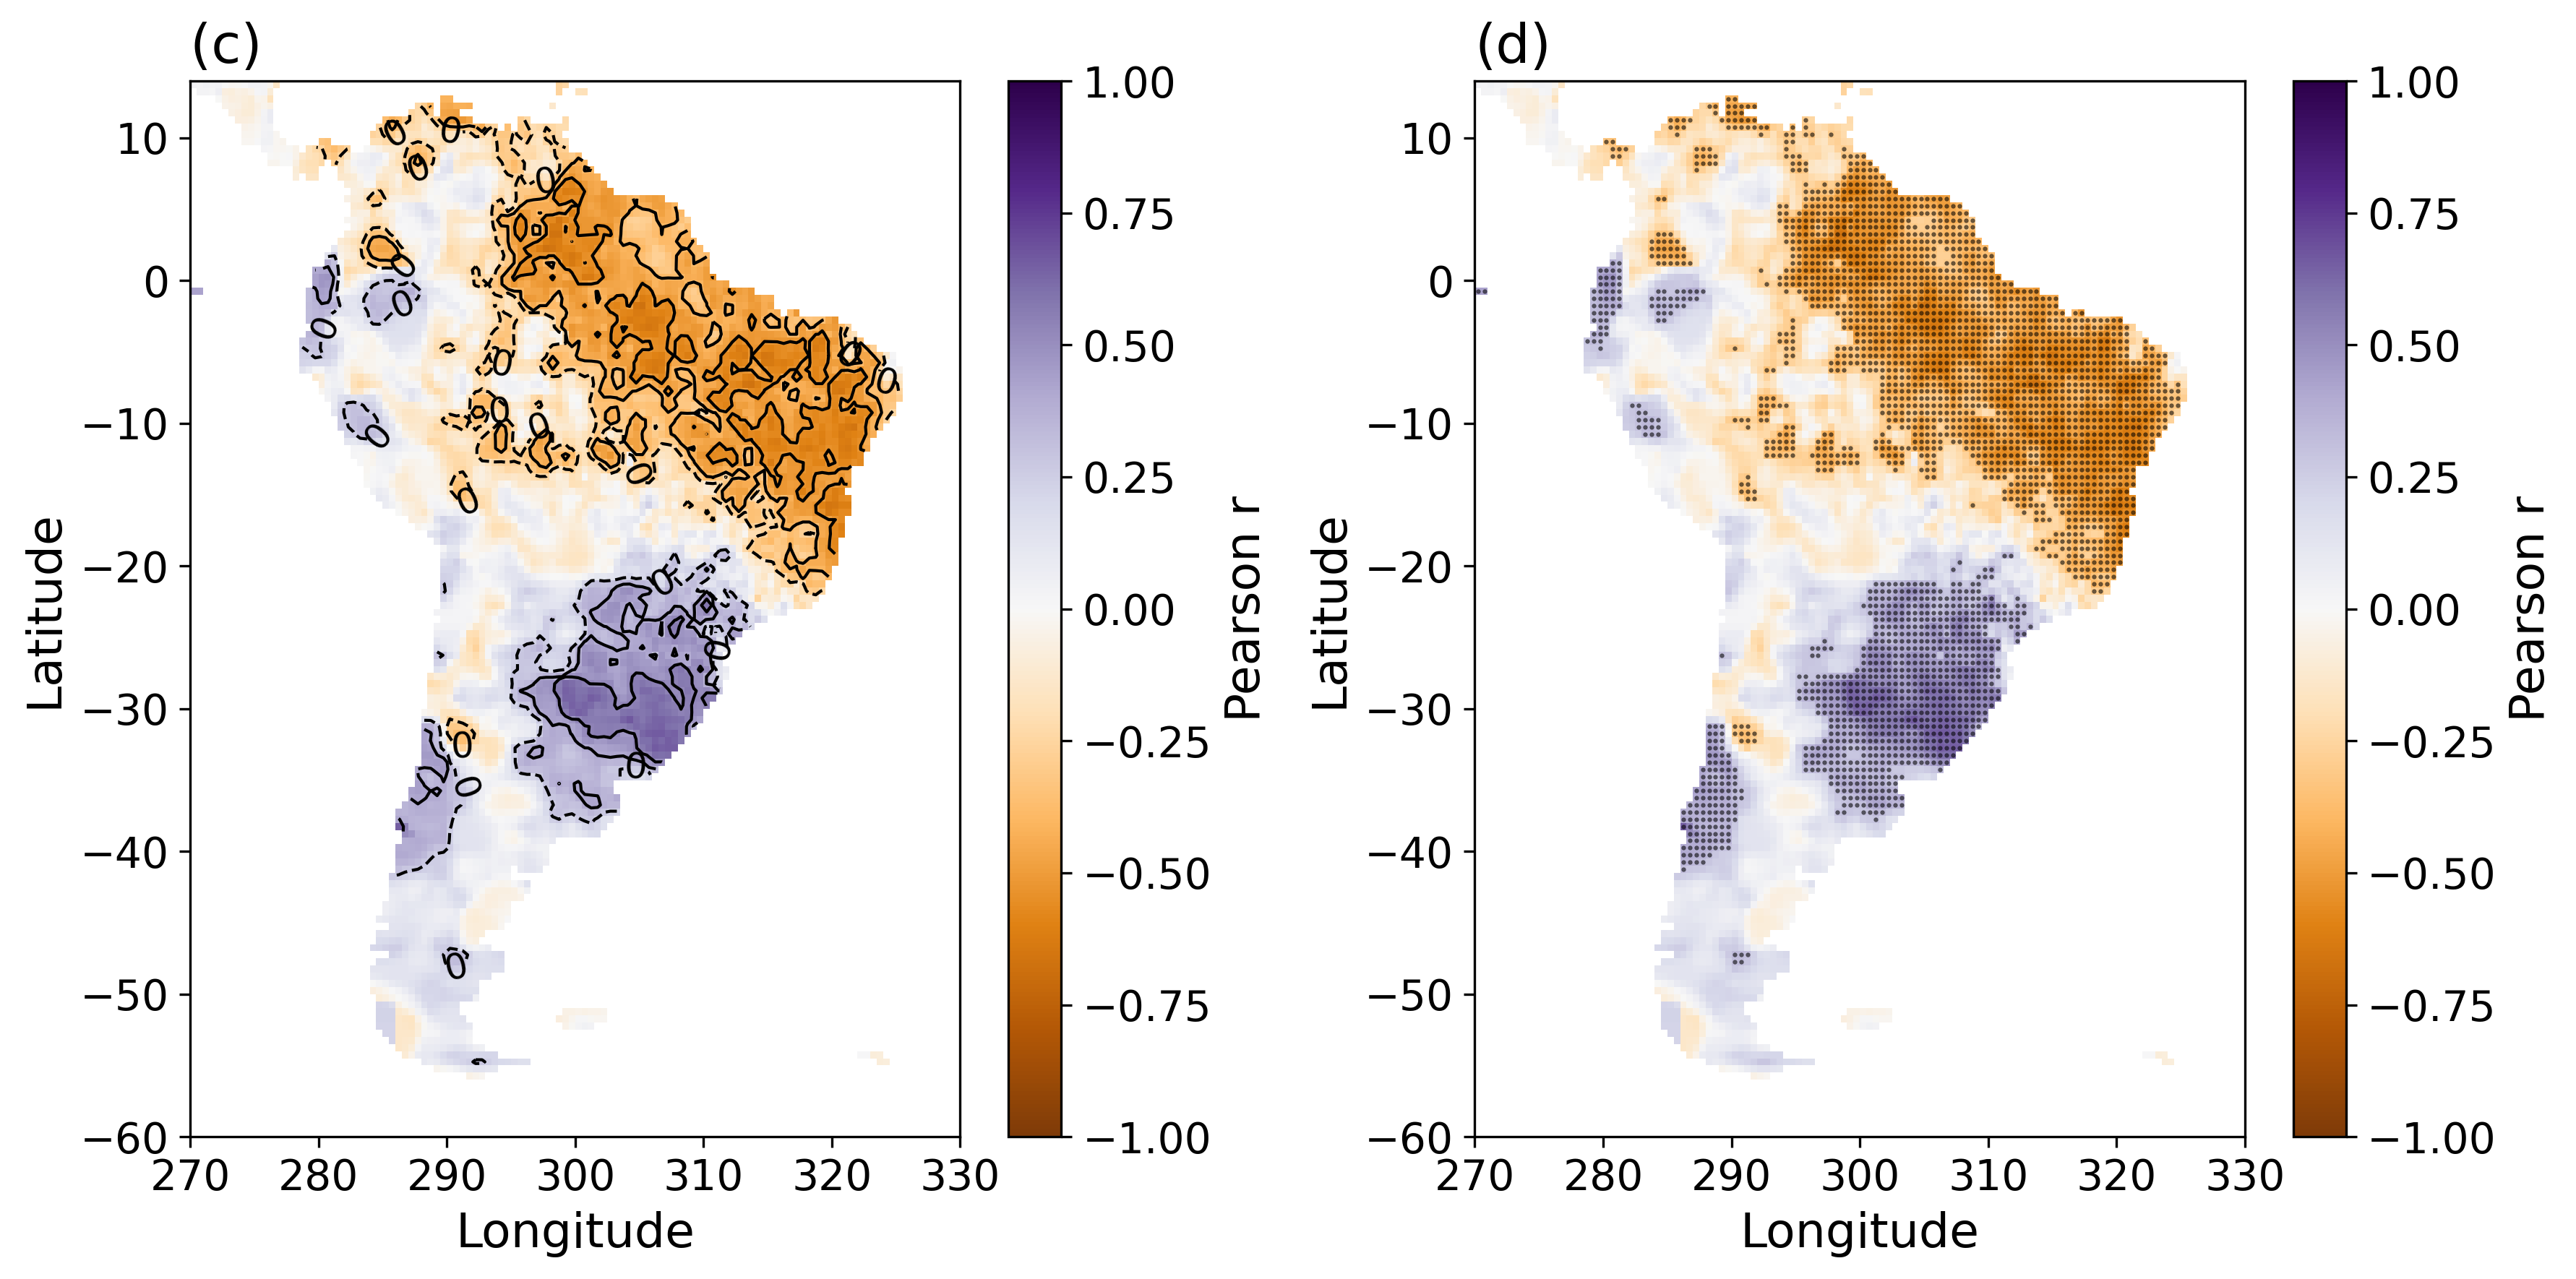

In [12]:
# === Limit to South America (assuming lon 0–360, lat ascending) ===
sa = dict(lon=slice(270, 330), lat=slice(14, -60))

r_sa = r_map_enso.sel(**sa)
bf_sa = bf_map_enso.sel(**sa)
p_sa = p_map_enso.sel(**sa)

bf_levels = [3, 100]
bf_levels_no_ev = [1/3]


fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# ============================
# (c) Correlation (r) map + BF contours
# ============================
im0 = axs[0].pcolormesh(
    r_sa['lon'], r_sa['lat'], r_sa,
    cmap='PuOr', vmin=-1, vmax=1
)

# axs[0].set_title(
#     '(c) ' + r'$\rho(\mathrm{ENSO}, \mathrm{PR_{x}})$',
#     fontsize=TITLE_FONTSIZE
# )

axs[0].set_title(
    '(c) ', loc='left',
    fontsize=TITLE_FONTSIZE
)

cs0 = axs[0].contour(
    bf_sa['lon'], bf_sa['lat'], bf_sa,
    levels=bf_levels,
    colors='k',
    linewidths=1
)

cs0 = axs[0].contour(
    bf_sa['lon'], bf_sa['lat'], bf_sa,
    levels=bf_levels_no_ev,
    colors='k',
    linewidths=1,
    linestyles='dashed'
)

axs[0].clabel(cs0, inline=True, fontsize=ANNOT_FONTSIZE, fmt='%d')

axs[0].set_xlabel('Longitude', fontsize=LABEL_FONTSIZE)
axs[0].set_ylabel('Latitude', fontsize=LABEL_FONTSIZE)
axs[0].tick_params(axis='both', labelsize=TICK_FONTSIZE)

cbar0 = fig.colorbar(im0, ax=axs[0], label='Pearson r')
cbar0.ax.tick_params(labelsize=TICK_FONTSIZE)
cbar0.set_label('Pearson r', fontsize=LABEL_FONTSIZE)

# ============================
# (d) Correlation map + stippling where p < 0.05
# ============================
im1 = axs[1].pcolormesh(
    r_sa['lon'], r_sa['lat'], r_sa,
    cmap='PuOr', vmin=-1, vmax=1
)

# axs[1].set_title(
#     '(d) Correlation (stippling where p < 0.05)',
#     fontsize=TITLE_FONTSIZE
# )

axs[1].set_title(
    '(d)', loc='left',
    fontsize=TITLE_FONTSIZE
)

# Create stippling mask
sig = p_sa < 0.05

# Build 2D lon/lat arrays for scatter
lon2d, lat2d = np.meshgrid(r_sa['lon'].values, r_sa['lat'].values)

# Stipple significant points
axs[1].scatter(
    lon2d[sig],
    lat2d[sig],
    s=1,
    color='k',
    marker='.',
    alpha=0.6
)

axs[1].set_xlabel('Longitude', fontsize=LABEL_FONTSIZE)
axs[1].set_ylabel('Latitude', fontsize=LABEL_FONTSIZE)
axs[1].tick_params(axis='both', labelsize=TICK_FONTSIZE)

cbar1 = fig.colorbar(im1, ax=axs[1], label='Pearson r')
cbar1.ax.tick_params(labelsize=TICK_FONTSIZE)
cbar1.set_label('Pearson r', fontsize=LABEL_FONTSIZE)

plt.tight_layout()

# If you still want to save just panel (c) as an image for later assembly:
# extent = axs[0].get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
# fig.savefig("panelC_D.png", dpi=300)  # or crop later in your layout tool


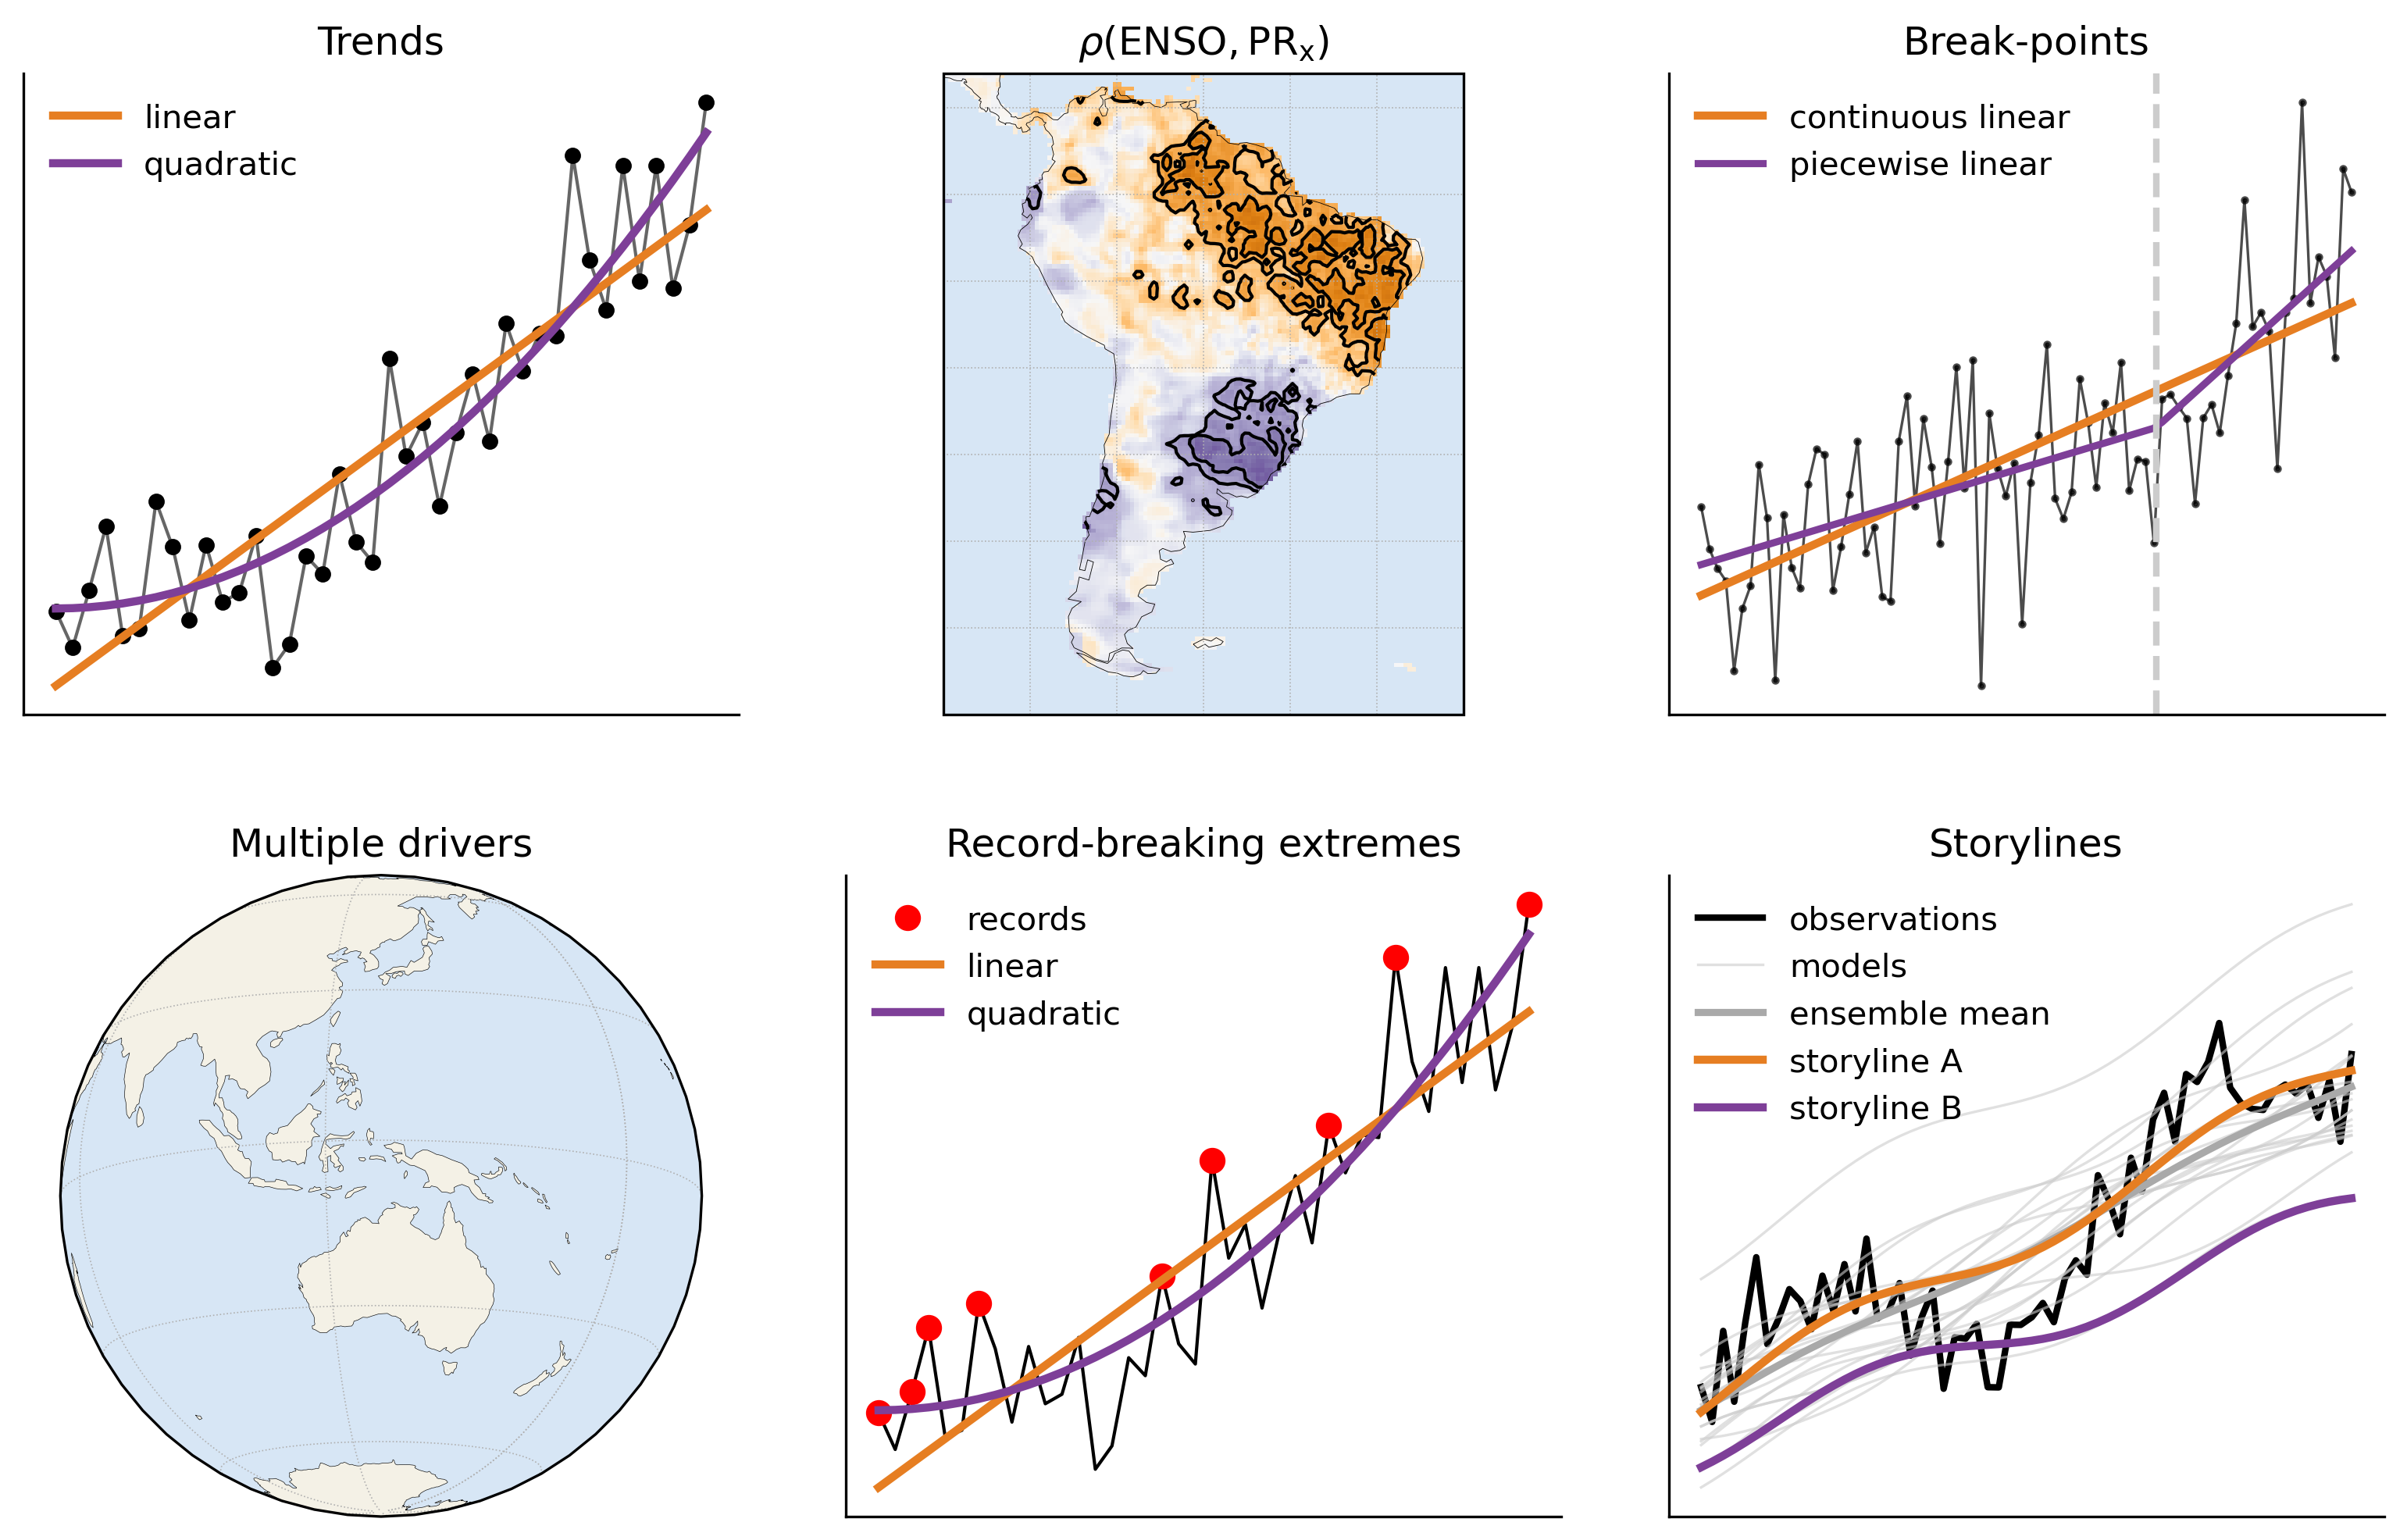

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

np.random.seed(42)

# Colors
ORANGE = "#e67e22"
PURPLE = "#7e3f98"
LIGHT_GREY = "#cccccc"

fig = plt.figure(figsize=(13, 8), dpi=300)

# Tighter space between panels
plt.subplots_adjust(wspace=0.15, hspace=0.25)

# ============================================================
# 1) TREND PANEL
# ============================================================
ax1 = fig.add_subplot(2, 3, 1)

x_trend = np.linspace(0, 10, 40)
y_true_trend = 0.3 * x_trend + 0.05 * x_trend**2 + 1
y_trend = y_true_trend + np.random.normal(scale=1.0, size=len(x_trend))

ax1.plot(x_trend, y_trend, "-", linewidth=1.0, color="black", alpha=0.6)
ax1.plot(x_trend, y_trend, "o", ms=4, color="black")

coef_lin = np.polyfit(x_trend, y_trend, 1)
y_lin = np.polyval(coef_lin, x_trend)
ax1.plot(x_trend, y_lin, linewidth=2.5, color=ORANGE, label="linear")

coef_quad = np.polyfit(x_trend, y_trend, 2)
y_quad = np.polyval(coef_quad, x_trend)
ax1.plot(x_trend, y_quad, linewidth=2.5, color=PURPLE, label="quadratic")

ax1.set_title("Trends", fontsize=12, pad=6)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.legend(fontsize=10, frameon=False)

# ============================================================
# 2) ENSO PANEL (Orthographic)
# ============================================================
# import matplotlib.image as mpimg

# ax2 = fig.add_subplot(2, 3, 2)
# img = mpimg.imread("panelA.png")

# ax2.imshow(img)
# ax2.axis("off")       # turn off ticks and frame
# ax2.set_title("Correlation", fontsize=12)


ax2 = fig.add_subplot(
    2, 3, 2,
    projection=ccrs.PlateCarree())

# Map background & coastlines
ax2.set_facecolor('#d7e6f5')
ax2.add_feature(cfeature.LAND.with_scale('110m'),
                facecolor='#f4f1e6', edgecolor='none')
ax2.coastlines(resolution='110m', linewidth=0.20)
gl = ax2.gridlines(linestyle=':', linewidth=0.4)

ax2.set_title(r'$\rho(\mathrm{ENSO}, \mathrm{PR_{x}})$', fontsize=12, pad=6)

# ============================================================
# 1) CORRELATION pcolormesh on projection
# ============================================================

# your grids
lon = r_sa['lon'].values
lat = r_sa['lat'].values
rmap = r_sa.values

# IMPORTANT: pcolormesh needs transform=PlateCarree for projected maps
im = ax2.pcolormesh(
    lon,
    lat,
    rmap,
    cmap='PuOr',
    vmin=-1, vmax=1,
    shading='auto',
    transform=ccrs.PlateCarree()
)

# ============================================================
# 2) BF CONTOURS
# ============================================================

bf_levels = [3,100]

cs = ax2.contour(
    bf_sa['lon'].values,
    bf_sa['lat'].values,
    bf_sa.values,
    levels=bf_levels,
    colors='k',
    linewidths=1.0,
    transform=ccrs.PlateCarree()
)

# ax2.clabel(cs, inline=True, fontsize=6, fmt='%d')

# ============================================================
# 3) BREAKPOINT PANEL
#    Two purple lines that touch at the breakpoint + orange linear trend
# ============================================================
ax3 = fig.add_subplot(2, 3, 3)

x_bp = np.linspace(0, 10, 80)
break_x = 7

# Define two lines that meet at break_x
m1, b1 = 0.3, 1.0             # first segment: y = m1*x + b1
m2 = 0.9                       # second segment slope
y_break = m1 * break_x + b1    # value at breakpoint for continuity
b2 = y_break - m2 * break_x    # second intercept so that lines meet

y_piecewise = np.where(
    x_bp <= break_x,
    m1 * x_bp + b1,
    m2 * x_bp + b2
)

y_bp_noisy = y_piecewise + np.random.normal(scale=1.2, size=len(x_bp))

# Data: black noisy line + markers
ax3.plot(x_bp, y_bp_noisy, "-", linewidth=0.8, color="black", alpha=0.7)
ax3.plot(x_bp, y_bp_noisy, ".", ms=3, color="black", alpha=0.7)

# Global linear trend (orange)
coef_lin_bp = np.polyfit(x_bp, y_bp_noisy, 1)
y_lin_bp = np.polyval(coef_lin_bp, x_bp)
ax3.plot(x_bp, y_lin_bp, linewidth=2.5, color=ORANGE,label='continuous linear')

# Breakpoint hypothesis: two purple segments touching at break_x
ax3.plot(x_bp, y_piecewise, linewidth=2.2, color=PURPLE,label='piecewise linear')

ax3.axvline(break_x, linestyle="--", color=LIGHT_GREY, linewidth=2)

ax3.set_title("Break-points", fontsize=12, pad=6)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.legend(fontsize=10, frameon=False)

# ============================================================
# 4) ENSO + IOD PANEL (Orthographic 130E, -10)
# ============================================================
ax4 = fig.add_subplot(
    2, 3, 4,
    projection=ccrs.Orthographic(central_longitude=130, central_latitude=-10)
)

ax4.set_facecolor('#d7e6f5')
ax4.add_feature(
    cfeature.LAND.with_scale('110m'),
    facecolor='#f4f1e6',
    edgecolor='none',
    zorder=1
)
ax4.coastlines(resolution='110m', linewidth=0.15, zorder=2)
ax4.gridlines(linestyle=':', linewidth=0.4)

ax4.set_title("Multiple drivers", fontsize=12, pad=6)

# ============================================================
# 5) EXTREMES PANEL (record-breaking on trend data)
# ============================================================
ax5 = fig.add_subplot(2, 3, 5)

ax5.plot(x_trend, y_trend, "-", linewidth=1.0, color="black")

records = []
current_max = -np.inf
for xi, yi in zip(x_trend, y_trend):
    if yi > current_max:
        records.append(True)
        current_max = yi
    else:
        records.append(False)
records = np.array(records)

ax5.plot(x_trend[records], y_trend[records], "o", ms=7, color="red", label="records")
ax5.plot(x_trend, y_lin, linewidth=2.5, color=ORANGE, label="linear")
ax5.plot(x_trend, y_quad, linewidth=2.5, color=PURPLE, label="quadratic")

ax5.set_title("Record-breaking extremes", fontsize=12, pad=6)
ax5.set_xticks([])
ax5.set_yticks([])
ax5.spines["top"].set_visible(False)
ax5.spines["right"].set_visible(False)
ax5.legend(fontsize=10, frameon=False)

# ============================================================
# 6) STORYLINES PANEL (spaghetti with 2 RANDOM highlighted models)
# ============================================================
ax6 = fig.add_subplot(2, 3, 6)

x_m = np.linspace(0, 10, 60)
y_obs = 0.4*x_m + np.sin(x_m) + np.random.normal(scale=0.4, size=len(x_m))

# Observations: black
ax6.plot(x_m, y_obs, linewidth=2, color="black", label="observations")

# Spaghetti: 20 candidate smooth models
model_curves = []
for i in range(20):
    slope = 0.4 + np.random.normal(scale=0.07)
    intercept = np.random.normal(scale=0.5)
    phase = np.random.uniform(0, 2*np.pi)
    wiggle = 0.25 * np.sin(x_m + phase)
    y_model = slope * x_m + intercept + wiggle
    model_curves.append(y_model)
    if i ==0:
        ax6.plot(x_m, y_model, linewidth=0.8, color=LIGHT_GREY, alpha=0.6, label="models")
    ax6.plot(x_m, y_model, linewidth=0.8, color=LIGHT_GREY, alpha=0.6)
    ### Add ensemble mean in darkgrey


### Add ensemble mean in dark grey
ensemble_mean = np.mean(model_curves, axis=0)
ax6.plot(
    x_m, ensemble_mean,
    color="darkgrey",
    linewidth=2.2,
    label="ensemble mean"
)
model_curves = np.array(model_curves)

# Choose two RANDOM distinct lines to highlight
idx_highlight = np.random.choice(len(model_curves), size=2, replace=False)
idx_a, idx_b = idx_highlight

ax6.plot(x_m, model_curves[idx_a], linewidth=2.5, color=ORANGE, label="storyline A")
ax6.plot(x_m, model_curves[idx_b], linewidth=2.5, color=PURPLE, label="storyline B")

ax6.set_title("Storylines", fontsize=12, pad=6)
ax6.set_xticks([])
ax6.set_yticks([])
ax6.spines["top"].set_visible(False)
ax6.spines["right"].set_visible(False)
ax6.legend(fontsize=10, frameon=False)

plt.show()


In [14]:
sst = xr.open_dataset('/climca/data/OBS/ERSSTv5/sst.mnmean.nc')

In [15]:
### Compute IOD index for 1979-2024 (SON) The IOD is calculated as the difference between sea surface temperature (SST) anomalies in the western (10°S–10°N, 50°–70°E) and eastern (10°S –0°, 90°–110°E) tropical Indian Ocean.
# Select SON months
sst_son = sst['sst'].sel(time=sst['time.month'].isin([10, 11, 12]))
# Group by year and compute mean
sst_son_annual = sst_son.groupby('time.year').mean(dim='time')
# Select regions
west_box = sst_son_annual.sel(lat=slice(10, -10), lon=slice(50, 70))
east_box = sst_son_annual.sel(lat=slice(10, -10), lon=slice(90, 110))
# Compute area-weighted mean SST in each box
def area_weighted_mean(da):
    weights = np.cos(np.deg2rad(da['lat']))
    weights /= weights.mean()
    return (da * weights).mean(dim=['lat', 'lon'])
sst_west = area_weighted_mean(west_box)
sst_east = area_weighted_mean(east_box)
# Compute IOD index
iod_index = sst_west - sst_east
iod_index = iod_index.sel(year=slice('1979','2024'))
iod_index.name = "IOD_index"
### Compute correlation between tmean and IOD for Sep-Nov


In [16]:
r_map_iod, bf_map_iod, p_map_iod = xr.apply_ufunc(
    compute_correlation_bf_p,
    pr_son_annual,
    iod_index,
    input_core_dims=[['year'], ['year']],
    output_core_dims=[[], [], []],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float, float, float],
    # or instead of explicit align: join='inner'
    # join='inner',
)

r_map_iod = r_map_iod.rename("r")
bf_map_iod = bf_map_iod.rename("BF10")
p_map_iod = p_map_iod.rename("p")

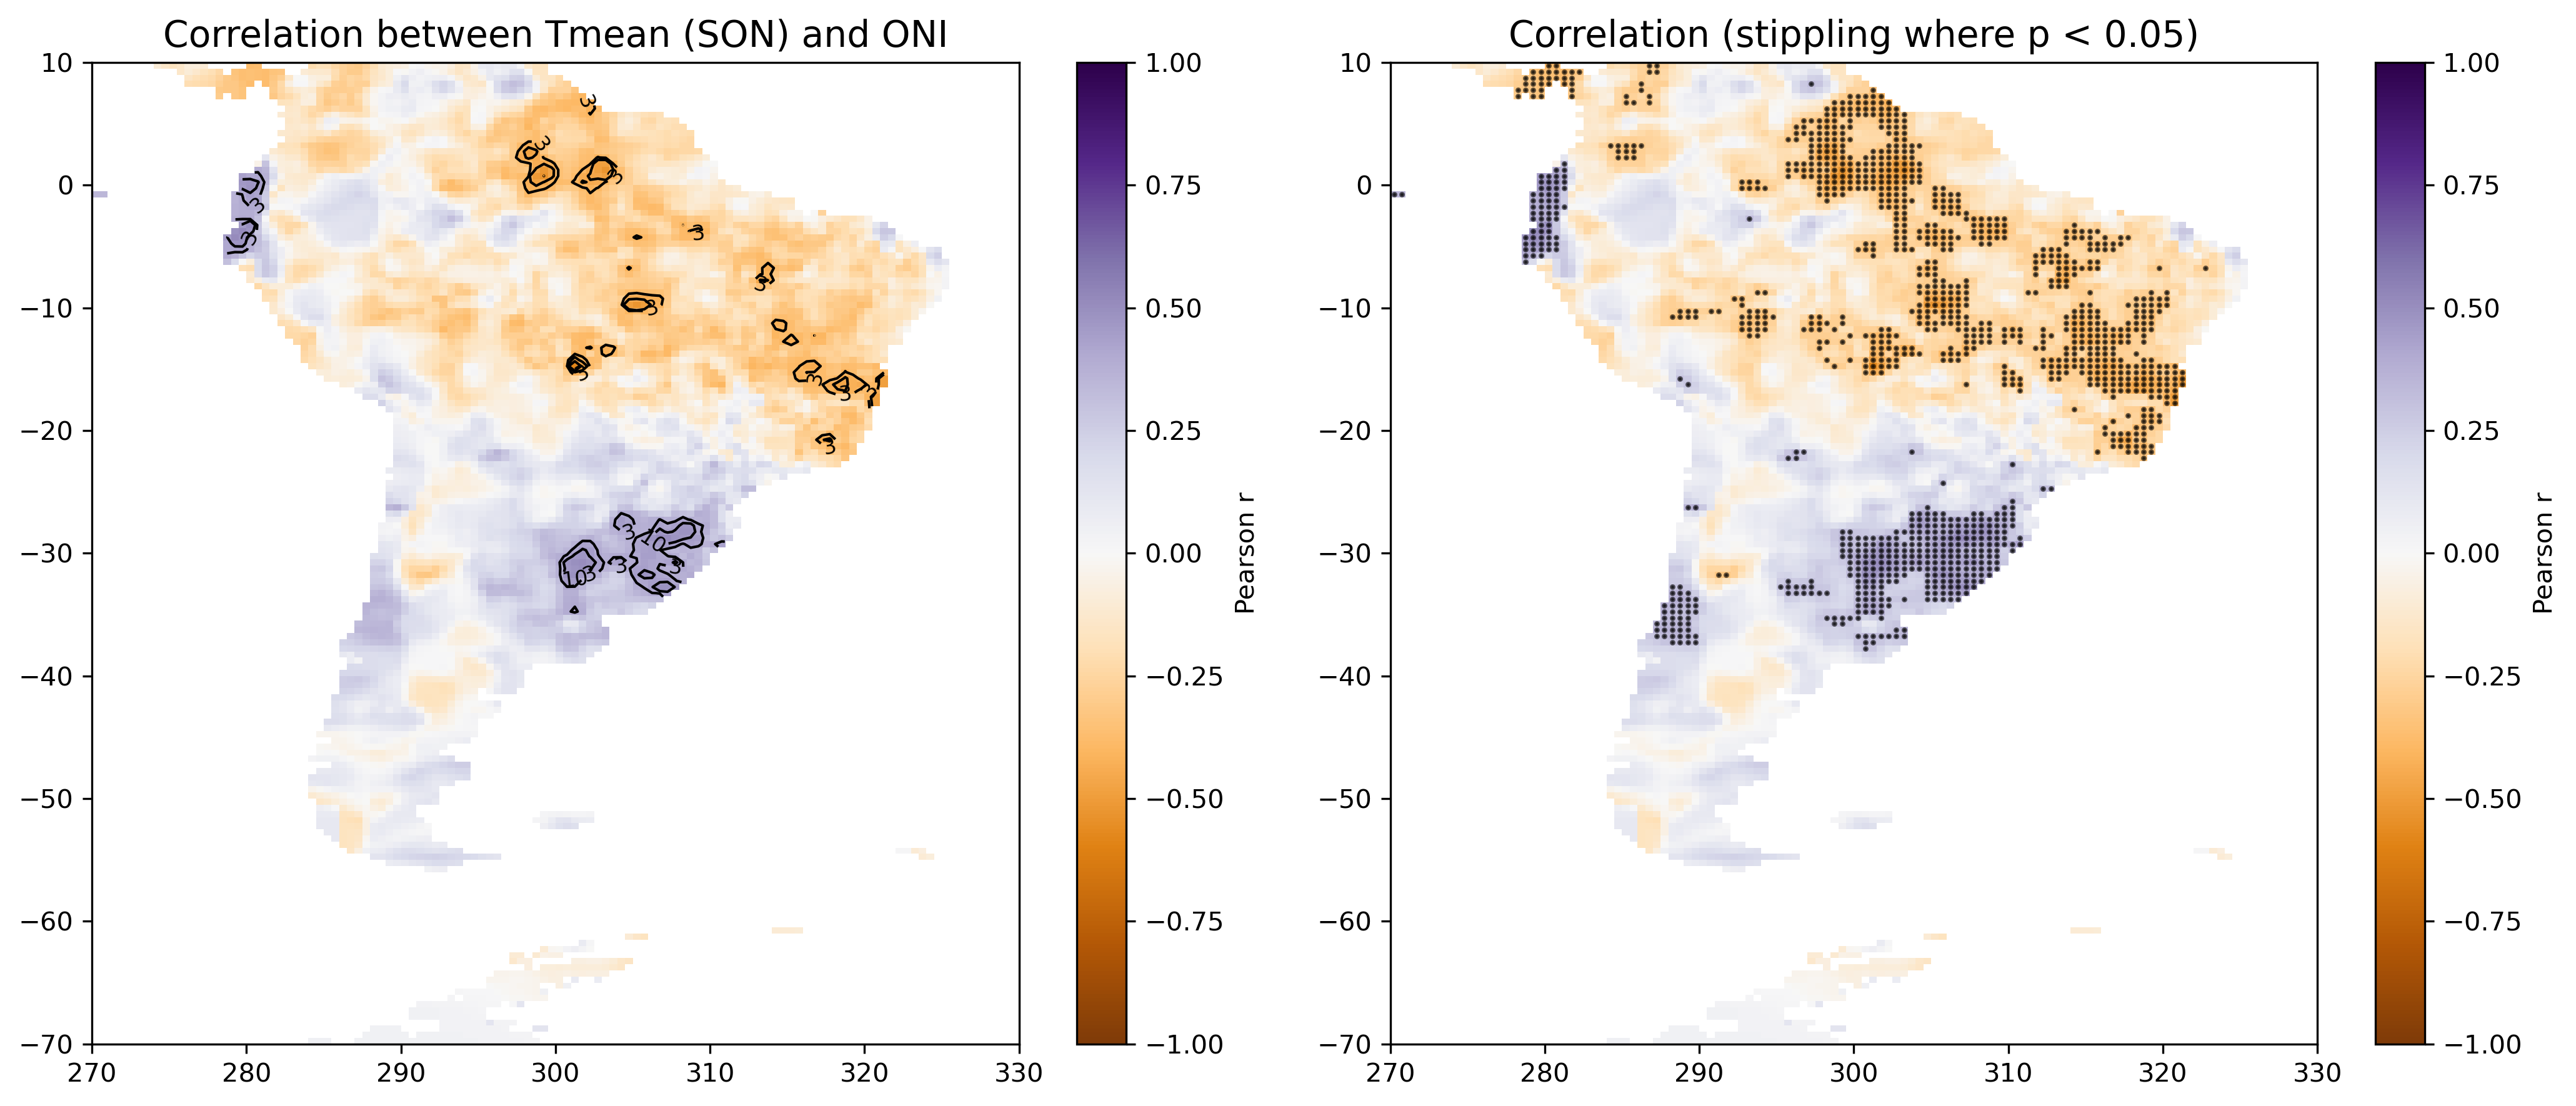

In [17]:

# === Limit to South America (assuming lon 0–360, lat ascending) ===
sa = dict(lon=slice(270, 330), lat=slice(10, -70))

r_sa = r_map_iod.sel(**sa)
bf_sa = bf_map_iod.sel(**sa)
p_sa = p_map_iod.sel(**sa)   # make sure you have p_map_pr from your apply_ufunc

bf_levels = [3, 10, 100]

fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=300)

# ============================
# 1) Correlation (r) map + BF contours
# ============================
im0 = axs[0].pcolormesh(
    r_sa['lon'], r_sa['lat'], r_sa,
    cmap='PuOr', vmin=-1, vmax=1
)
axs[0].set_title('Correlation between Tmean (SON) and ONI', fontsize=14)

cs0 = axs[0].contour(
    bf_sa['lon'], bf_sa['lat'], bf_sa,
    levels=bf_levels,
    colors='k',
    linewidths=1
)
axs[0].clabel(cs0, inline=True, fontsize=8, fmt='%d')

fig.colorbar(im0, ax=axs[0], label='Pearson r')

# ============================
# 2) Correlation map + stippling where p < 0.05
# ============================
im1 = axs[1].pcolormesh(
    r_sa['lon'], r_sa['lat'], r_sa,
    cmap='PuOr', vmin=-1, vmax=1
)
axs[1].set_title('Correlation (stippling where p < 0.05)', fontsize=14)

# Create stippling mask
sig = p_sa < 0.05

# Build 2D lon/lat arrays for scatter
lon2d, lat2d = np.meshgrid(r_sa['lon'].values, r_sa['lat'].values)

# Stipple significant points
axs[1].scatter(
    lon2d[sig],
    lat2d[sig],
    s=5,
    color='k',
    marker='.',
    alpha=0.6
)

fig.colorbar(im1, ax=axs[1], label='Pearson r')

plt.tight_layout()
plt.show()

In [18]:
from scipy.stats import f

def compute_mlr_bf_p(y, X):
    """
    Multi-linear regression with detrending and standardization.

    Parameters
    ----------
    y : 1D array (n,)
        Response along 'year'.
    X : 2D array (n, k)
        Predictors along 'year' (columns are different predictors).

    Returns
    -------
    r : float
        Correlation between y and fitted values (signed multiple correlation).
    BF10 : float
        Bayes factor for full model vs null (likelihood ratio under Gaussian errors).
    p : float
        p-value for overall F-test of the regression.
    """
    y = np.asarray(y)
    X = np.asarray(X)

    # Handle NaNs: drop rows where y or any predictor is NaN
    mask = np.isfinite(y) & np.all(np.isfinite(X), axis=1)
    y_ = y[mask]
    X_ = X[mask, :]

    if y_.ndim != 1:
        raise ValueError("y must be 1D")
    if X_.ndim != 2:
        raise ValueError("X must be 2D (n, k)")

    n, k = X_.shape
    if n <= k + 1:
        return np.nan, np.nan, np.nan

    t = np.arange(n)

    # --- detrend and standardize y ---
    coef_y = np.polyfit(t, y_, 1)
    trend_y = np.polyval(coef_y, t)
    y_d = y_ - trend_y
    y_std = y_d.std(ddof=1)
    if y_std == 0 or not np.isfinite(y_std):
        return np.nan, np.nan, np.nan
    y_z = (y_d - y_d.mean()) / y_std

    # --- detrend and standardize each column of X ---
    X_z = np.empty_like(X_, dtype=float)
    for j in range(k):
        xj = X_[:, j]
        coef_x = np.polyfit(t, xj, 1)
        trend_x = np.polyval(coef_x, t)
        xj_d = xj - trend_x
        xj_std = xj_d.std(ddof=1)
        if xj_std == 0 or not np.isfinite(xj_std):
            return np.nan, np.nan, np.nan
        X_z[:, j] = (xj_d - xj_d.mean()) / xj_std

    # Design matrix with intercept
    X_design = np.column_stack([np.ones(n), X_z])  # (n, k+1)

    # OLS via least squares
    beta_hat, _, _, _ = np.linalg.lstsq(X_design, y_z, rcond=None)
    y_hat = X_design @ beta_hat

    # Sum of squares
    SSE_full = np.sum((y_z - y_hat)**2)
    SSE_null = np.sum((y_z - y_z.mean())**2)

    if SSE_null == 0:
        return np.nan, np.nan, np.nan

    R2 = 1.0 - SSE_full / SSE_null

    # Multiple correlation (signed) between y and y_hat
    r, _ = pearsonr(y_z, y_hat)

    # Bayes factor via likelihood ratio (Gaussian errors)
    if SSE_full <= 0:
        BF10 = np.nan
    else:
        BF10 = (SSE_null / SSE_full) ** (n / 2.0)

    # Overall F-test
    if (n - k - 1) <= 0 or R2 >= 1:
        p = np.nan
    else:
        F_stat = (R2 / k) / ((1.0 - R2) / (n - k - 1))
        p = 1.0 - f.cdf(F_stat, k, n - k - 1)

    return r, BF10, p
